<h1 style="color: blue;">라. 얼굴 인식 실습</h1>

얼굴 정렬을 수행하기 위해 여러 가지 방법을 사용할 수 있습니다. 눈 주변에만 집중하는 간단한 방법을 사용 하여 정렬해보겠습니다.

다음과 같은 프로세스로 진행
1. 이미지에서 얼굴과 눈 감지 
2. 감지된 눈의 중심 계산
3. 두 눈 중앙 사이에 선을 그어 기준선 생성
4. 두 눈 사이의 수평선 그리기
5. 삼각형의 세 변의 길이 계산
6. 각도 계산
7. 계산된 각도로 이미지 회전
8. 이미지 크기 조정

## 1. 얼굴 및 눈 감지를 위해 OpenCV Haar 캐스케이드 구성

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [11]:
face_cascade = cv2.CascadeClassifier("../data/hearcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("../data/haarcascade_eye.xml")

[ERROR:0@1595.754] global persistence.cpp:512 open Can't open file: '../data/hearcascade_frontalface_default.xml' in read mode


### 얼굴 이미지 데이터 읽기

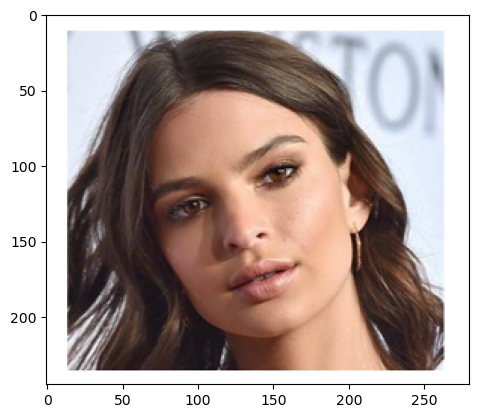

In [12]:
face_image = cv2.imread('../data/face01.png')
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
face_image_copy = face_image.copy()

plt.imshow(face_image)
plt.show()

## 2. 얼굴 이미지 바운딩 박스 처리 : 케이케이드 경우는 그레이 스케일 이미지에서만 작동

얼굴 객체 인식 좌표: 49 48 160 160


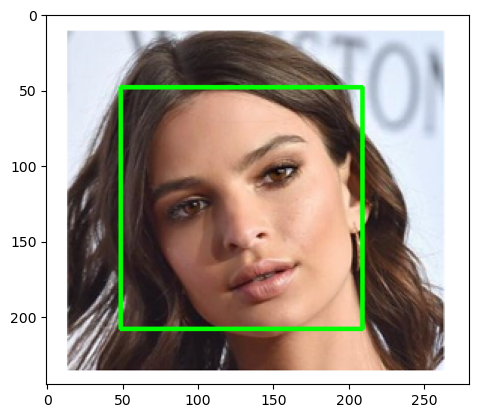

In [13]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

face_gray_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

faces_box_info = face_cascade.detectMultiScale(face_gray_image, 1.1, 4)

for (x, y, w, h) in faces_box_info:
    print("얼굴 객체 인식 좌표:", x, y, w, h)
    cv2.rectangle(face_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(face_image)
plt.show()

## 3. 눈 감지

[[30 63 33 33]
 [81 37 42 42]]
0 30 63 33 33
1 81 37 42 42


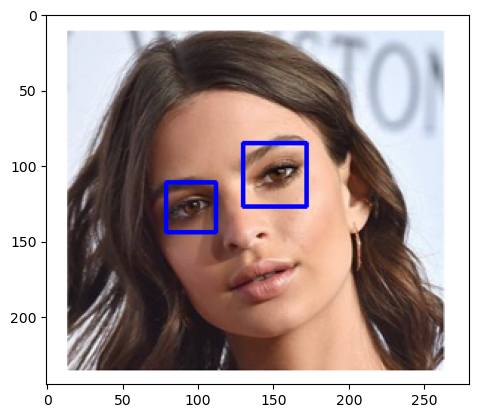

In [14]:
roi_gray = face_gray_image[y:(y+h), x:(x+w)]
roi_color = face_image_copy[y:(y+h), x:(x+w)]

eyes_box_info = eye_cascade.detectMultiScale(roi_gray)

print(eyes_box_info)

for i, (ex, ey, ew, eh) in enumerate(eyes_box_info) :
    print(i, ex, ey, ew, eh)
    if i == 0 :
        eye_1 = (ex, ey, ew, eh)
    elif i == 1 :
        eye_2 = (ex, ey, ew, eh)
        
    cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,0,255), 2)

plt.imshow(face_image_copy)
plt.show()

## 4. 얼굴 정렬

In [15]:
print(eye_1[0], eye_2[0])

if eye_1[0] < eye_2[0] :
    left_eye = eye_1
    right_eye = eye_2
else :
    left_eye = eye_2
    right_eye = eye_1

    print(left_eye, right_eye)

30 81


left eye center 좌표 :  46 79
right eye center 좌표 :  102 58


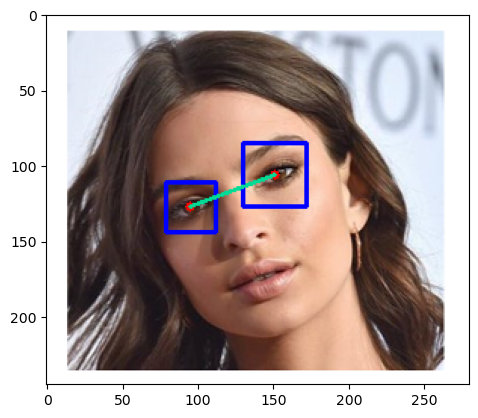

In [16]:
left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2))) 
left_eye_center_x = left_eye_center[0]
left_eye_center_y = left_eye_center[1]

print("left eye center 좌표 : ", left_eye_center_x,left_eye_center_y)

right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))
right_eye_center_x = right_eye_center[0]
right_eye_center_y = right_eye_center[1]

print("right eye center 좌표 : ", right_eye_center_x,right_eye_center_y)

cv2.circle(roi_color, left_eye_center, 3, (255,0,0), -1)
cv2.circle(roi_color, right_eye_center, 3, (255,0,0), -1)
cv2.line(roi_color, left_eye_center, right_eye_center, (0,220,150), 2)

plt.imshow(face_image_copy)
plt.show()

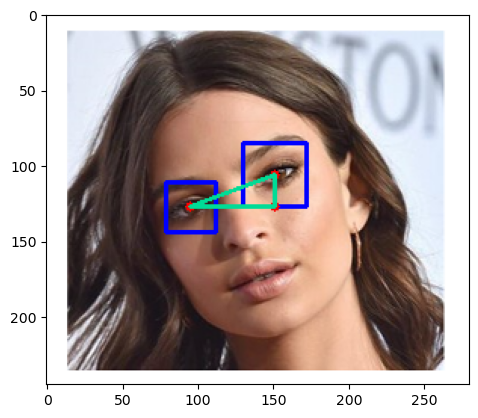

In [17]:
if left_eye_center_y > right_eye_center_y :
    A = (right_eye_center_x, left_eye_center_y)
    direction = -1
else :
    A = (left_eye_center_x, right_eye_center_y)
    direction = 1
    
cv2.circle(roi_color, A, 3, (255,0,0), -1)
cv2.line(roi_color, left_eye_center, A, (0,220,150), 2)
cv2.line(roi_color, right_eye_center, A, (0,220,150), 2)

plt.imshow(face_image_copy)
plt.show()

## 5. 각도 계산

In [18]:
delta_x = right_eye_center_x - left_eye_center_x
delta_y = right_eye_center_y - left_eye_center_y

angle = np.arctan(delta_y / delta_x)
angle = (angle * 180) / np.pi
print(angle)

-20.556045219583464


## 6. 이미지를 각도 세타만큼 회전

이미지 height, width 값 >>  245 280
image center values >>  (140, 122)
[[  0.93632918  -0.35112344  51.75097501]
 [  0.35112344   0.93632918 -41.38944149]]


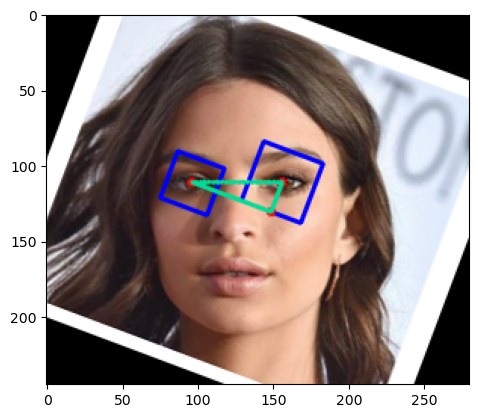

In [19]:
height, width, _ = face_image_copy.shape
print("이미지 height, width 값 >> ", height, width)

image_center = (width // 2 , height // 2)
print("image center values >> ", image_center)

M = cv2.getRotationMatrix2D(image_center, (angle), 1.0)
print(M)

rotated = cv2.warpAffine(face_image_copy, M, (width,height))

plt.imshow(rotated)
plt.show()